In [29]:
using ComputationalHeatTransfer
using LaTeXStrings
using JLD2
using Plots
plotly()  

Plots.PlotlyBackend()

## Get fluid properties

In [30]:
fluid_type = "butane"
Tᵥ = 291.2

291.2

## Read data

In [31]:
pwd()

"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks"

In [69]:
# OHPdata = load("/Users/yuxuanli/Documents/OHPnume/Ca13E05_DT2/ASETS-II OHP 1 LARGE HEATER_10W.jld2")
OHPdata = load("/Users/yuxuanli/Documents/Hoffman/ohp80/OHPnume/OHP2_40W_large_plus0.65 _minus0.6 .jld2")
# OHPdata = load("/Users/yuxuanli/Documents/Hoffman/ohp63/OHPnume/ASETS-II OHP 1 LARGE HEATER_40W.jld2")
# OHPdata = load("/Users/yuxuanli/Documents/Hoffman/ohp67/OHPnume/ASETS-II OHP 2 LARGE HEATER_30W.jld2")
power = 40


40

In [70]:
#     power = 20
#     OHPdata = load(dirname(dirname(dirname(pwd())))*"/OHPnume/d1.5e-3/"*namei);
    
    ohp = OHPdata["ohp"]
    boil_data = OHPdata["boil_data"]
    tube_hist_t = OHPdata["tube_hist_t"]
    tube_hist_θwall = OHPdata["tube_hist_θwall"]
    tube_hist_u = OHPdata["tube_hist_u"]
    integrator_tube = OHPdata["integrator_tube"]
    sysfinal = getsysfinal(tube_hist_u,tube_hist_θwall,integrator_tube);

    plate_T_hist = OHPdata["plate_T_hist"]

    integrator_plate = OHPdata["integrator_plate"]
    sys = integrator_plate.p
    
    x = [-2.75inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
#     x = [-2.9inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.9inch]
    y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];
    X =  VectorData(x,y);
    H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
    g = ScalarData(X);
    ghist = getghist(g,H,plate_T_hist);
    thist = tube_hist_t;

## Get RTD result for OHP

In [71]:
import XLSX

In [72]:
# xf = XLSX.readxlsx("20190613_F_PD_#004_O001_H001_P040_expA.xlsx")
# starti = 3603
# RTD = xf["Raw Data!G:N"][starti:end,:];
# RTDt = (1:size(RTD,1)) .+ starti;

In [73]:
    "20190607_F_PD_%23013_O001_H002_P010_expA.xlsx";
    "20190608_F_PD_%23014_O001_H002_P020_expA.xlsx";
    "20190614_F_PD_%23015_O001_H002_P030_expA.xlsx";
    "20190617_F_PD_%23016_O001_H002_P040_expA.xlsx";
    "20190604_F_PD_%23001_O001_H001_P010_expA.xlsx";
    "20190606_F_PD_%23002_O001_H001_P020_expA.xlsx";
    "20190612_F_PD_%23003_O001_H001_P030_expA.xlsx";
    "20190613_F_PD_%23004_O001_H001_P040_expA.xlsx";
    "20190607_F_PD_%23017_O002_H002_P010_expA.xlsx";
    "20190608_F_PD_%23018_O002_H002_P020_expA.xlsx";
    "20190614_F_PD_%23019_O002_H002_P030_expA.xlsx";
    "20190617_F_PD_%23020_O002_H002_P040_expA.xlsx";
    "20190604_F_PD_%23005_O002_H001_P010_expA.xlsx";
    "20190606_F_PD_%23006_O002_H001_P020_expA.xlsx";
    "20190612_F_PD_%23007_O002_H001_P030_expA.xlsx";
    "20190613_F_PD_%23008_O002_H001_P040_expA.xlsx";

In [74]:
# namei = "20190604_F_PD_%23005_O002_H001_P010_expA.xlsx"
# namei = "20190606_F_PD_%23006_O002_H001_P020_expA.xlsx"
# namei = "20190612_F_PD_%23007_O002_H001_P030_expA.xlsx"
namei = "20190613_F_PD_%23008_O002_H001_P040_expA.xlsx"
# namei = "20190613_F_PD_%23004_O001_H001_P040_expA.xlsx"
# namei = "20190612_F_PD_%23003_O001_H001_P030_expA.xlsx"
# namei =     "20190604_F_PD_%23001_O001_H001_P010_expA.xlsx";
#  namei =    "20190606_F_PD_%23002_O001_H001_P020_expA.xlsx";

xf = XLSX.readxlsx(dirname(dirname(dirname(pwd())))*"/OHPexp/"*namei)
    Onum, Hnum, power_exp = getconfig(namei)
    RTD,RTDt = getRTD(xf,Onum);

## boiling frequency

In [75]:
Xstations = sysfinal[end].wall.Xstations;
tend = boil_data[end,2]
boil_dt = 0.1;

In [76]:
using SparseArrays 

In [77]:
boil_matrix=spzeros(size(Xstations,1),Int64(round(tend/boil_dt)));
for tnum = 1:size(boil_matrix,2)
     boil_index = findall(x->Int64(round(x/boil_dt))==tnum,boil_data[:,2])

    if length(boil_index) != 0
        i_station_temp = Int64.(boil_data[boil_index,1])
        for i in i_station_temp
            boil_matrix[i,tnum] = 1
        end
    end
end


In [78]:
boil_num_t = sum(boil_matrix, dims=1)'
boil_num_x = sum(boil_matrix, dims=2);
t_boil = boil_dt:boil_dt:boil_dt*length(boil_num_t)

0.1:0.1:5.0

In [79]:
using EasyFit
m10 = movavg(vec(boil_num_t),10);

## Contour graphs

┌ Info: Saved animation to /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/slug_fps15.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/io9zQ/src/animation.jl:156


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/slug_fps15.gif")
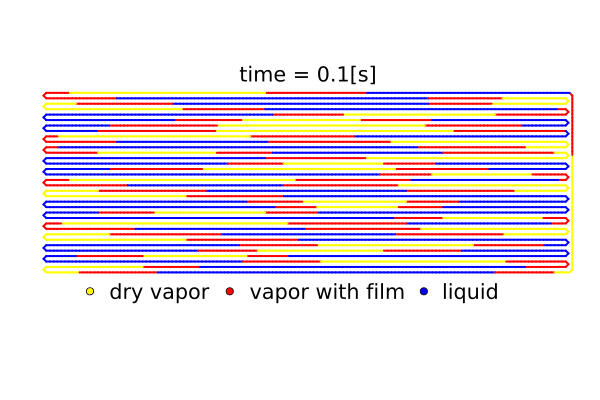

In [80]:
gr()
Hₗ = sysfinal[1].liquid.Hₗ
adjust = 1e-2;

anim = @animate for i=1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),
        line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
        annotate!(0.0, 0.028, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false)
    scatter!([-0.066+adjust],[-0.028],color=:yellow);scatter!([-0.03+adjust],[-0.028],color=:red);scatter!([0.02+adjust],[-0.028],color=:blue);
    annotate!(-0.05+0.002+adjust, -0.028, "dry vapor", :black)
    annotate!(-0.01+0.005+adjust, -0.028, "vapor with film", :black)
    annotate!(0.03+0.002+adjust, -0.028, "liquid", :black)
end
gif(anim, "slug_fps15.gif", fps = 10)

In [31]:
gr()
ii = [5,10,15,20,100,300]

l = @layout [a b; c d; e f]
i = ii[1]
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
  p1 =   plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),xlimit=xlim,ylimit=ylim,
        line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
  p1 = annotate!(0.0, 0.03, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false,fontsize=8)
 
i = ii[2]
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
  p2 =   plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),xlimit=xlim,ylimit=ylim,
        line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
  p2 = annotate!(0.0, 0.03, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false,fontsize=8)
 
i = ii[3]
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
  p3 =   plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),xlimit=xlim,ylimit=ylim,
        line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
  p3 = annotate!(0.0, 0.03, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false,fontsize=8)
 
i = ii[4]
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
  p4 =   plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),xlimit=xlim,ylimit=ylim,
        line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
  p4 = annotate!(0.0, 0.03, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false,fontsize=8)

i = ii[5]
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
  p5 =   plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),xlimit=xlim,ylimit=ylim,
        line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
  p5 = annotate!(0.0, 0.03, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false,fontsize=8)
 
i = ii[6]
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
  p6 =   plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),xlimit=xlim,ylimit=ylim,
        line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
  p6 = annotate!(0.0, 0.03, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false,fontsize=8)
 
pp = plot(p1, p2, p3, p4, p5, p6, layout = l, size=(600,450), margin=-2*Plots.mm);

savefig("ohp normal.pdf")

LoadError: UndefVarError: xlim not defined

In [32]:
# ii = [5,10,15,20,100,300]

# l = @layout [a b; c d; e f]
# i = ii[1]
#     Htmp = sys_to_Harray(sysfinal[i])
#     Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
#   p1 =   plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),xlimit=xlim,ylimit=ylim,
#         line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
# #   p1 = annotate!(0.0, 0.03, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false,fontsize=8)
 
# i = ii[1]
#    p2 = heatmap(plate_T_hist[i],sys.grid,legend=false,color=cgrad(:thermal),
#         xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xtick=false,ytick=false,border=:none,axis=nothing,bbox_inches="tight")
#   p2 = annotate!(0.045, -0.028, text(string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white, 10))
 

# i = ii[2]
#     Htmp = sys_to_Harray(sysfinal[i])
#     Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
#   p3 =   plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),xlimit=xlim,ylimit=ylim,
#         line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
# #   p1 = annotate!(0.0, 0.03, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false,fontsize=8)
 

# i = ii[2]
#    p4 = heatmap(plate_T_hist[i],sys.grid,legend=false,color=cgrad(:thermal),
#         xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xtick=false,ytick=false,border=:none,axis=nothing,bbox_inches="tight")
#   p4 = annotate!(0.045, -0.028, text(string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white, 10))
 
# i = ii[3]
#     Htmp = sys_to_Harray(sysfinal[i])
#     Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
#   p5 =   plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :red]),xlimit=xlim,ylimit=ylim,
#         line_z=Htmp_marker,xlabel="x ",ylabel="y ",border=:none,axis=nothing,bbox_inches="tight")
# #   p1 = annotate!(0.0, 0.03, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :black,legend=false,fontsize=8)
 

# i = ii[3]
#    p6 = heatmap(plate_T_hist[i],sys.grid,legend=false,color=cgrad(:thermal),
#         xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xtick=false,ytick=false,border=:none,axis=nothing,bbox_inches="tight")
#   p6 = annotate!(0.045, -0.028, text(string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white, 10))
 
# pp = plot(p1, p2, p3, p4, p5, p6, layout = l, margin=-2*Plots.mm);

# savefig("ohp.pdf")

### plate T [K]

In [68]:
#     scatter!(pp,[-0.066+adjust],[-0.028],color=:yellow);scatter!([-0.03+adjust],[-0.028],color=:red);scatter!([0.02+adjust],[-0.028],color=:blue);
#     annotate!(pp,-0.05+0.002+adjust, -0.028, "dry vapor", :black)
#     annotate!(pp,-0.01+0.005+adjust, -0.028, "vapor with film", :black)
#     annotate!(pp,0.03+0.002+adjust, -0.028, "liquid", :black)

In [69]:
gr()
Tmax = maximum(plate_T_hist[end])
Tmin = minimum(plate_T_hist[1])
xlim = integrator_plate.p.grid.xlim[1]
ylim = integrator_plate.p.grid.xlim[2]


(-0.03356673188700064, 0.03356673188700064)

In [70]:
  h2 = scatter([0,0], [0,1], zcolor=[0,3], clims=clims,
                 xlims=(1,1.1), xshowaxis=false, yshowaxis=false, label="", c=:viridis, colorbar_title="cbar", grid=false)


LoadError: UndefVarError: clims not defined

In [71]:
Tmax

303.6315662641306

In [72]:
Tmin

291.2005692805342

In [73]:
gr()
ii = [5,10,15,20,100,300]

l = @layout [Plots.grid(3, 2) a{0.1w}]

h2 = scatter([1,1],markeralpha=0,zcolor=[0,0], clim=(Tmin,Tmax),
                  xshowaxis=false, yshowaxis=false, label="",  colorbar_title="\n T[K]", grid=false,right_margin = 5Plots.mm)

i = ii[1]
p1 = heatmap(plate_T_hist[i],sys.grid,legend=false,color=cgrad(:thermal),
        xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xtick=false,ytick=false,bottom_margin = 0Plots.mm)
p1 = annotate!(0.04, -0.028, text(string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white, 10))

i = ii[2]
p2 = heatmap(plate_T_hist[i],sys.grid,legend=false,color=cgrad(:thermal),
        xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xtick=false,ytick=false,bottom_margin = 0Plots.mm)
p2 = annotate!(0.04, -0.028, text(string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white, 10))


i = ii[3]
p3 = heatmap(plate_T_hist[i],sys.grid,legend=false,color=cgrad(:thermal),
        xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xtick=false,ytick=false,bottom_margin = 0Plots.mm)
p3 = annotate!(0.04, -0.028, text(string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white, 10))


i = ii[4]
p4 = heatmap(plate_T_hist[i],sys.grid,legend=false,color=cgrad(:thermal),
        xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xtick=false,ytick=false,bottom_margin = 0Plots.mm)
p4 = annotate!(0.04, -0.028, text(string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white, 10))


i = ii[5]
p5 = heatmap(plate_T_hist[i],sys.grid,legend=false,color=cgrad(:thermal),
        xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xtick=false,ytick=false,bottom_margin = 0Plots.mm)
p5 = annotate!(0.04, -0.028, text(string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white, 10))


i = ii[6]
p6 = heatmap(plate_T_hist[i],sys.grid,legend=false,color=cgrad(:thermal),
        xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xtick=false,ytick=false,bottom_margin = 0Plots.mm)
p6 = annotate!(0.04, -0.028, text(string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white, 10))


plot(p1, p2, p3, p4, p5, p6, h2, layout = l,margin=0*Plots.mm,size=(600,350),xtick=false,ytick=false)

savefig("T contour normal.pdf")

GKS: Rectangle definition is invalid in routine SET_VIEWPORT


"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/T contour normal.pdf"

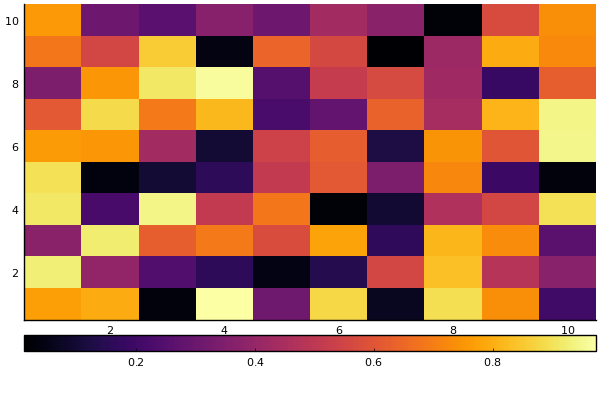

In [105]:
pyplot()
heatmap(rand(10,10),colorbar=:bottom)

In [33]:
# gr()
# Tmax = maximum(plate_T_hist[end])
# Tmin = minimum(plate_T_hist[1])
# xlim = integrator_plate.p.grid.xlim[1]
# ylim = integrator_plate.p.grid.xlim[2]

# anim = @animate for i = 1:1:length(sysfinal)
# # @gif for i = 1:1:1
# heatmap(plate_T_hist[i],sys.grid,legend=true,color=cgrad(:thermal),
#         xlimit=xlim,ylimit=ylim,clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",
#         colorbar_title = "\n T[K]",right_margin = 5Plots.mm)
# scatter!([x[1],x[4],x[8]],[y[1],y[4],y[8]])
# annotate!(x[1]+0.002, y[1]+0.005, "RTD1", :white)
# annotate!(x[4]+0.002, y[4]+0.005, "RTD4", :white)
# annotate!(x[8]-0.001, y[8]+0.005, "RTD8", :white)
# annotate!(0.05, -0.028, string("time = ", round(tube_hist_t[i], digits=2), "[s]"), :white,legend=false)
# end
# gif(anim, "temperature_fps15.gif", fps = 10)

## temperature curve

In [44]:
Tᵥ = 291.2

291.2

In [24]:
# pyplot()
i = 1 #RTD number

# p1 = plot(thist,ghist[i] .-Tᵥ, color=:red, label=string("RTD", i," simulation"),linewidth=2,legend = :topleft)
p1 = scatter(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:red, label=string("RTD", i," experiment"))

i = 4 #RTD number

# plot!(thist,ghist[i] .-Tᵥ, color=:green, label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:green, label=string("RTD", i," experiment"))

i = 8 #RTD number
# plot!(thist,ghist[i] .-Tᵥ,color=:orange,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:orange, label=string("RTD", i," experiment"),
    xlabel="time [s]",ylabel="T-T₀ [K]",xlim=(0,600),title=("OHP2 large heater 40W: dryout"),legend = :topleft)

savefig(p1,"dryout.pdf")

"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/dryout.pdf"

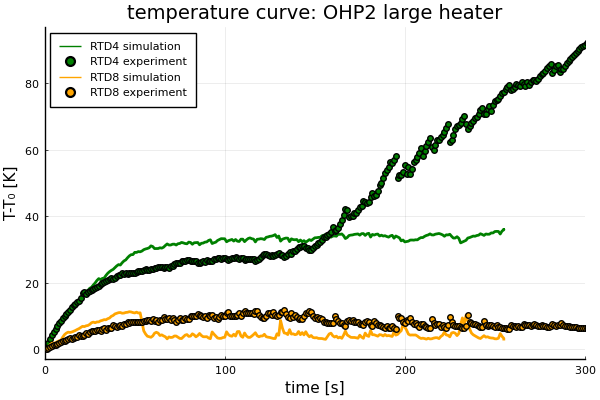

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [66]:
# pyplot()
# i = 1 #RTD number

# p1 = plot(thist,ghist[i] .-Tᵥ, color=:red, label=string("RTD", i," simulation"),linewidth=2,legend = :topleft)
# scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:red, label=string("RTD", i," experiment"))

i = 4 #RTD number

p1 = plot(thist,ghist[i] .-Tᵥ, color=:green, label=string("RTD", i," simulation"),linewidth=2,legend = :topleft)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:green, label=string("RTD", i," experiment"))

i = 8 #RTD number
plot!(thist,ghist[i] .-Tᵥ,color=:orange,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], color=:orange, label=string("RTD", i," experiment"),
    xlabel="time [s]",ylabel="T-T₀ [K]",xlim=(0,300),title=("temperature curve: OHP2 large heater"))

# savefig(p1,"temp_curve dryout.pdf")

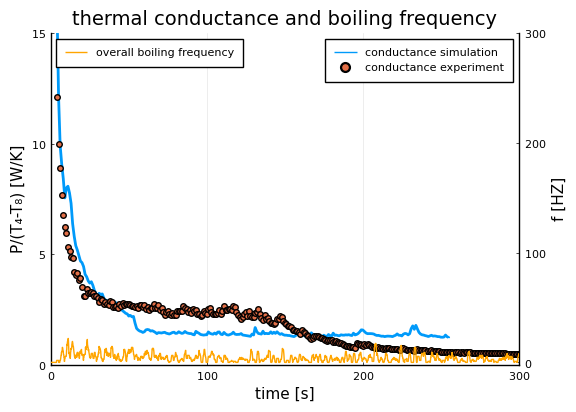

"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/cond_curve normal.pdf"

In [67]:
pyplot()
i1 = 4 #RTD number
i2 = 8 #RTD number

p1 = plot(thist,power./(ghist[i1] .-ghist[i2]), right_margin=10Plots.mm,label=string("conductance simulation"),linewidth=2,legend=:topright)
scatter!(RTDt .- RTDt[1],power./(RTD[:,i1] .- RTD[:,i2]), label=string("conductance experiment"),
    xlim=(0,300),ylim=(0,15),title="thermal conductance and boiling frequency",xlabel="time [s]",ylabel="P/(T₄-T₈) [W/K]")
plot!(twinx(), t_boil,m10.x./boil_dt, color=:orange, legend=:topleft, ylabel="f [HZ]",ylim=(-2,300),xlim=(0,thist[end]),label="overall boiling frequency")
# plot!(right_bottom=10Plots.mm)
savefig(p1,"cond_curve normal.pdf")

## boilng site

In [57]:
using Interpolations

In [58]:
ql = sys.qline[1]
interp_linear_x = LinearInterpolation(ql.arccoord, ql.body.x,extrapolation_bc = Line());
interp_linear_y = LinearInterpolation(ql.arccoord, ql.body.y,extrapolation_bc = Line());

xstations = interp_linear_x[sysfinal[end].wall.Xstations]
ystations = interp_linear_y[sysfinal[end].wall.Xstations];

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


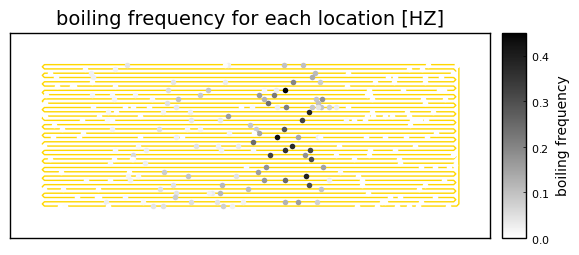

"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/boilingsite.pdf"

In [59]:
ohp = sys.qline[1].body
gd = sys.grid
scatter()
plot!(ohp,fillalpha=0,xlim=gd.xlim[1],ylim=gd.xlim[2],linecolor=:gold,framestyle = :box)
scatter!(xstations,ystations,marker_z=boil_num_x[:]./tend,
    colorbar_title = "boiling frequency",markerstrokewidth=0,markercolor=cgrad(:greys, rev = true),
    axis=nothing,title="boiling frequency for each location [HZ]")

savefig("boilingsite.pdf")

## dXdt distribution

In [60]:
using Statistics

In [61]:
Vavg_hist = []
Vmax_hist = []
Vmin_hist = []
for sysi in sysfinal
    V = [elem[2] for elem in sysi.liquid.dXdt]
#     Vavg = mean(abs.(V))
    Vavg = mean(V)
    Vmax = maximum((V))
    Vmin = minimum((V))
    
    push!(Vavg_hist, Vavg)
    push!(Vmax_hist, Vmax)
    push!(Vmin_hist, Vmin)
end

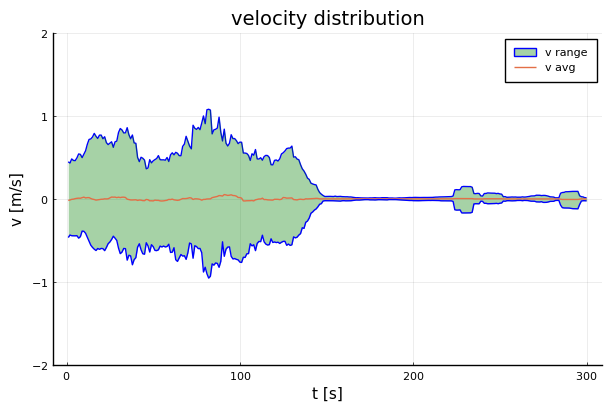

"/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/velocity dryout.pdf"

In [81]:
plot(thist,movavg(Float64.(Vmax_hist),10).x,label="v range",fillalpha = 0.35, c = :blue,fillrange = movavg(Float64.(Vmin_hist),10).x,fillcolor=:green)
# plot!(thist,movavg(Float64.(Vavg_hist),10).x,label="|v| avg")
plot!(thist,movavg(Float64.(Vavg_hist),10).x,label="v avg")
plot!(thist,movavg(Float64.(Vmin_hist),10).x,ylim=(-2,2),color=:blue, label=false, xlabel="t [s]", ylabel="v [m/s]",title="velocity distribution")
savefig("velocity dryout.pdf")

In [395]:
U = mean(Vavg_hist)

0.250886471805685

## OHP film thickness correlation

In [396]:

velocity_avg = zeros(length(sysfinal))
velocity_max = zeros(length(sysfinal))

for i = 1:length(sysfinal)
    tmp = 0
    for j = length(sysfinal[i].liquid.dXdt)
        tmp += abs(sysfinal[i].liquid.dXdt[j][1])
    
        velocity_avg[i] = tmp/j
    end
    
    velocity_max[i] = maximum(abs.(sysfinal[i].liquid.dXdt[:][1]))
end



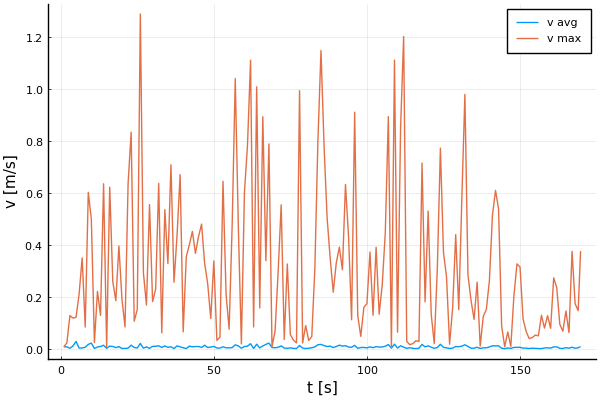

In [38]:
plot(thist,velocity_avg,label="v avg")
plot!(thist,velocity_max,label="v max",xlabel="t [s]", ylabel="v [m/s]")

In [39]:
d_tube = sysfinal[end].tube.d

0.001

### Range of Re
### $Re = \frac{\rho_{\mathrm{l}} v d}{\mu_{\mathrm{l}}}$



In [40]:
Re_avg = d_tube*ρₗ .* velocity_avg / μₗ
Re_max = d_tube*ρₗ .* velocity_max / μₗ;

LoadError: UndefVarError: ρₗ not defined

In [41]:
plot(thist,Re_avg,label="v avg")
plot!(thist,Re_max,label="v max",xlabel="t [s]", ylabel="Re")

LoadError: UndefVarError: Re_avg not defined

In [42]:
integrator_tube.p.vapor.δ

LoadError: type Vapor has no field δ

In [43]:
δ_corr = integrator_tube.p.tube.d * (0.67 .* Ca.^(2/3)) ./ ( 1 .+ 3.35 .* Ca.^(2/3))

LoadError: UndefVarError: Ca not defined

In [ ]:
δ_corr = integrator_tube.p.tube.d * (0.67 .* Ca2.^(2/3)) ./ ( 1 .+ 3.35 .* Ca2.^(2/3))

In [ ]:
using UnPack

p_fluid = SaturationFluidProperty(fluid_type,Tᵥ)
@unpack Cpₗ,ρₗ,μₗ,hₗ,kₗ,Prₗ,Cpᵥ,ρᵥ,μᵥ,hᵥ,kᵥ,Prᵥ,σ,P,R,M,Rkg,αₗ,νₗ,νᵥ,hₗᵥ = p_fluid;

In [ ]:
# U = 0.48 #m/s

Ca = U .* μₗ ./σ

In [ ]:
tube_d = 1e-3

In [ ]:
Ca_star1 = (μₗ^2/(σ * ρₗ * tube_d/2))^(3/4)

In [ ]:
Ca_star2 = (μₗ^2/(σ * ρₗ * tube_d/2))^(1/2)

In [ ]:
Ca^(2/3)/(1+Ca^(2/3)) *tube_d/2

In [ ]:
sysfinal[1].wall.ΔTthres

In [ ]:
sysfinal[1].vapor.δ

In [ ]:
l = @layout [a b ; c d]
pltindex=[5,15,25,100]
p1 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[1]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[1]].t, digits=2), "[s]")) 
p2 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[2]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[2]].t, digits=2), "[s]")) 
p3 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[3]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[3]].t, digits=2), "[s]")) 
p4 = histogram(filmδcorr(getCa(μₗ,σ,[elem[2] for elem in sysfinal[pltindex[4]].liquid.dXdt]),sysfinal[1].tube.d),bins=0e-5:2e-6:5e-5,ylim=(0,20),title=string("t=",round(plate_hist[pltindex[4]].t, digits=2), "[s]")) 
plot(p1, p2, p3, p4, layout = l,titlefontsize=10,labelfontsize=10,xticks=1e-5:2e-5:5e-5,legend=false,xlabel="δ [m]",ylabel="N of vapor",plot_title="film thickness histogram")

In [ ]:
i = 100
velocity = 
Ca = 

plot(δfilm)

In [ ]:
velocity = [elem[1] for i =1:]getCa(μ,σ,velocity)

In [ ]:
ρₗ-ρᵥ

In [ ]:
bo = (ρₗ-ρᵥ).*9.8*(1e-3)^2/σ

In [ ]:
μₗ.*1.0/σ

In [ ]:
function getCa(μ,σ,velocity)
    Ca = abs.(μ.*velocity./σ)
end

function filmδcorr(Ca,d)
    filmδ = d .* 0.67.*Ca.^(2/3)./(1 .+ 3.35.*Ca.^(2/3))
end

## Film thickness graphs

In [ ]:
@gif for i=length(sysfinal):length(sysfinal)
    plot(sysfinal[i].vapor.δ,xlabel="vapor label",ylabel="film thickness [m]", label = "δ",ylim=(5e-6,1.5e-5))
end

## boiling graph

In [ ]:
boil_data = load("OHP1_40W.jld2","boil_data");

In [ ]:
Xstations = sysfinal[end].wall.Xstations;

In [ ]:
tend = boil_data[end,2]
boil_dt = 0.1;

In [ ]:
using SparseArrays 

In [ ]:
boil_matrix=spzeros(size(Xstations,1),Int64(round(tend/boil_dt)));
for tnum = 1:size(boil_matrix,2)
     boil_index = findall(x->Int64(round(x/boil_dt))==tnum,boil_data[:,2])

    if length(boil_index) != 0
        i_station_temp = Int64.(boil_data[boil_index,1])
        for i in i_station_temp
            boil_matrix[i,tnum] = 1
        end
    end
end


In [ ]:
boil_num_t = sum(boil_matrix, dims=1)'
boil_num_x = sum(boil_matrix, dims=2);

In [ ]:
using EasyFit

m10 = movavg(vec(boil_num_t),10)


In [ ]:
m10.R

In [ ]:
plot(0.1:0.1:300.0,m10.x,xlabel="t",ylabel="N",title="number of active boiling sites (moving averaged)",legend=false)

In [ ]:
savefig("boiling frequency.pdf")

In [ ]:
boiling

In [ ]:
num_boiling = zeros(size(Xstations))
for i = 1:size(boil_data,1)
    num_boiling[Int64(sorted_boil_hist[i,1])] += 1
end
freq_boiling = num_boiling/tend;

In [ ]:
sorted_boil_hist = boil_data[sortperm(boil_data[:, 1]), :]
num_boiling = zeros(size(Xstations))
for i = 1:size(sorted_boil_hist,1)
    num_boiling[Int64(sorted_boil_hist[i,1])] += 1
end
freq_boiling = num_boiling/tend;

In [ ]:
scatter(xstations,freq_boiling,xlabel="x[m]",ylabel="boiling frequency [HZ]",legend=false)

In [ ]:
scatter(ystations,freq_boiling,xlabel="y[m]",ylabel="boiling frequency [HZ]",legend=false)

In [ ]:
ohp = load("ohp.jld2","ohp")

In [ ]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
# Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


In [ ]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)
scatter!(xstations,ystations)

In [ ]:
savefig("boiling sites.svg")

In [ ]:
Lliquid = XptoLliquidslug(sysfinal[end].liquid.Xp,sysfinal[end].tube.L)

sum(Lliquid)/sysfinal[end].tube.L

In [ ]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [ ]:
plate_d = 2e-3
tube_d = 1e-3

In [ ]:
(Lx*Ly*plate_d - sysfinal[1].tube.L * tube_d^2)/(Lx*Ly)

In [ ]:
boil_data

In [ ]:
sys = sysfinal[end]
dXdt = sys.liquid.dXdt;
μₗ = sys.liquid.μₗ;
σ = sys.liquid.σ;
Ca = getCa.(μₗ,σ,dXdt)
d = sys.tube.d

In [ ]:
using Statistics
V = [elem[2] for elem in sys.liquid.dXdt]
    Vavg = mean(abs.(V))
Ca = getCa.(μₗ,σ,Vavg)
Catoδ.(d,Ca)

In [ ]:
function Catoδ(d,Ca;adjust_factor=1,δmin=5e-6,δmax=1e-4)

    δ = Ca .^ (2/3) ./ (1 .+ Ca .^ (2/3)) .* d ./ 2 .* adjust_factor
    if (δ < δmin)
        return δmin
    elseif (δ > δmax)
        return δmax
    else 
        return δ
    end
end

In [ ]:
Catoδ.(d,3e-3)

In [122]:
integrator_tube.u = tube_hist_u[end]


2892-element Vector{Float64}:
   0.20676132819272253
   0.31066244226727385
   0.3690476330100511
   0.41149572107419424
   0.4765481248059955
   0.4877832810740589
   0.4919313818546966
   0.5752184214630605
   0.6283248394680581
   0.6392211686952582
   0.6422917836446017
   0.6566086137073649
   0.7289796792249882
   ⋮
 332.3094020261535
 332.44541059423625
 332.5874563652818
 332.73283665692975
 332.8795369753362
 333.02643947469676
 333.1730102864142
 333.3191384917439
 333.4657459711614
 333.62028152361853
 333.8558324121611
 334.90851403864025

In [121]:
reinit!(integrator_tube)

retcode: Default
Interpolation: 3rd order Hermite
t: 1-element Vector{Float64}:
 0.0
u: 1-element Vector{Vector{Float64}}:
 [3.85368059817451, 3.9566851103493894, 4.008702939802427, 4.096120723666443, 4.163725281430345, 4.222170800950396, 4.318747623058262, 4.389625053593891, 4.47376996468618, 4.5837781770829  …  291.2, 291.2, 291.2, 291.2, 291.2, 291.2, 291.2, 291.2, 291.2, 291.2]

In [108]:
? integrator_tube

search: integrator_tube integrator_to_heatflux integrator_to_Harray



No documentation found.

`integrator_tube` is of type `OrdinaryDiffEq.ODEIntegrator{RK4, false, Vector{Float64}, Nothing, Float64, PHPSystem, Float64, Float64, Float64, Float64, Vector{Vector{Float64}}, ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, false, PHPSystem, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, RK4, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, OrdinaryDiffEq.RK4ConstantCache}, DiffEqBase.DEStats, Nothing}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, OrdinaryDiffEq.RK4ConstantCache, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, Float64, PIController{Rational{Int64}}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(LinearAlgebra.opnorm), Nothing, CallbackSet{Tuple{}, Tuple{DiscreteCallback{typeof(fixdx_condition), typeof(fixdx_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(boiling_condition), typeof(boiling_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(merging_condition), typeof(merging_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(vaporMergingCondition), typeof(vaporMergingAffect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}, Vector{Float64}, Float64, Nothing, OrdinaryDiffEq.DefaultInit}`.

# Summary

```
mutable struct OrdinaryDiffEq.ODEIntegrator{RK4, false, Vector{Float64}, Nothing, Float64, PHPSystem, Float64, Float64, Float64, Float64, Vector{Vector{Float64}}, ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, false, PHPSystem, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, RK4, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, OrdinaryDiffEq.RK4ConstantCache}, DiffEqBase.DEStats, Nothing}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, OrdinaryDiffEq.RK4ConstantCache, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, Float64, PIController{Rational{Int64}}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(LinearAlgebra.opnorm), Nothing, CallbackSet{Tuple{}, Tuple{DiscreteCallback{typeof(fixdx_condition), typeof(fixdx_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(boiling_condition), typeof(boiling_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(merging_condition), typeof(merging_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(vaporMergingCondition), typeof(vaporMergingAffect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}, Vector{Float64}, Float64, Nothing, OrdinaryDiffEq.DefaultInit}
```

# Fields

```
sol                    :: ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, false, PHPSystem, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, RK4, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, OrdinaryDiffEq.RK4ConstantCache}, DiffEqBase.DEStats, Nothing}
u                      :: Vector{Float64}
du                     :: Nothing
k                      :: Vector{Vector{Float64}}
t                      :: Float64
dt                     :: Float64
f                      :: ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}
p                      :: PHPSystem
uprev                  :: Vector{Float64}
uprev2                 :: Vector{Float64}
duprev                 :: Nothing
tprev                  :: Float64
alg                    :: RK4
dtcache                :: Float64
dtchangeable           :: Bool
dtpropose              :: Float64
tdir                   :: Float64
eigen_est              :: Float64
EEst                   :: Float64
qold                   :: Float64
q11                    :: Float64
erracc                 :: Float64
dtacc                  :: Float64
success_iter           :: Int64
iter                   :: Int64
saveiter               :: Int64
saveiter_dense         :: Int64
cache                  :: OrdinaryDiffEq.RK4ConstantCache
callback_cache         :: Nothing
kshortsize             :: Int64
force_stepfail         :: Bool
last_stepfail          :: Bool
just_hit_tstop         :: Bool
do_error_check         :: Bool
event_last_time        :: Int64
vector_event_last_time :: Int64
last_event_error       :: Float64
accept_step            :: Bool
isout                  :: Bool
reeval_fsal            :: Bool
u_modified             :: Bool
reinitialize           :: Bool
isdae                  :: Bool
opts                   :: OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, Float64, PIController{Rational{Int64}}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(LinearAlgebra.opnorm), Nothing, CallbackSet{Tuple{}, Tuple{DiscreteCallback{typeof(fixdx_condition), typeof(fixdx_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(boiling_condition), typeof(boiling_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(merging_condition), typeof(merging_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(vaporMergingCondition), typeof(vaporMergingAffect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}
destats                :: DiffEqBase.DEStats
initializealg          :: OrdinaryDiffEq.DefaultInit
fsalfirst              :: Vector{Float64}
fsallast               :: Vector{Float64}
```

# Supertype Hierarchy

```
OrdinaryDiffEq.ODEIntegrator{RK4, false, Vector{Float64}, Nothing, Float64, PHPSystem, Float64, Float64, Float64, Float64, Vector{Vector{Float64}}, ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, false, PHPSystem, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, RK4, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, OrdinaryDiffEq.RK4ConstantCache}, DiffEqBase.DEStats, Nothing}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(ODE_innertube), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, OrdinaryDiffEq.RK4ConstantCache, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, Float64, PIController{Rational{Int64}}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(LinearAlgebra.opnorm), Nothing, CallbackSet{Tuple{}, Tuple{DiscreteCallback{typeof(fixdx_condition), typeof(fixdx_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(boiling_condition), typeof(boiling_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(merging_condition), typeof(merging_affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(vaporMergingCondition), typeof(vaporMergingAffect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, DataStructures.BinaryHeap{Float64, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}, Vector{Float64}, Float64, Nothing, OrdinaryDiffEq.DefaultInit} <: SciMLBase.AbstractODEIntegrator{RK4, false, Vector{Float64}, Float64} <: SciMLBase.DEIntegrator{RK4, false, Vector{Float64}, Float64} <: Any
```


In [144]:
integrator_tube

t: 0.0244313836783532
u: 2659-element Vector{Float64}:
   3.839474672258706
   3.9424791844335854
   4.018140608139974
   4.1055583920039895
   4.1784909475906895
   4.23693646711074
   4.305369192371105
   4.376246622906733
   4.462742874166196
   4.572751086562916
   4.601034214254685
   0.052121667890446394
   0.16665906496319735
   ⋮
 292.37180363452956
 292.36604737711895
 292.3595587119047
 292.35231735893615
 292.3442838337972
 292.33540871463975
 292.32565777619254
 292.31501582715487
 292.3034497385941
 292.29092286307775
 292.2905454883519
 309.58858689495503

In [143]:
step!(integrator_tube,1e-3)

In [46]:
ad_fac = 1.3
tstep = 1e-3

0.001

In [47]:
sysfinal[end].liquid.Xp

48-element Vector{Tuple{Float64, Float64}}:
 (0.20676132819272253, 0.31066244226727385)
 (0.3690476330100511, 0.41149572107419424)
 (0.4765481248059955, 0.4877832810740589)
 (0.4919313818546966, 0.5752184214630605)
 (0.6283248394680581, 0.6392211686952582)
 (0.6422917836446017, 0.6566086137073649)
 (0.7289796792249882, 0.7391592246728488)
 (0.7467464474911948, 0.8374399666726542)
 (0.89008323631058, 0.9057978875658376)
 (0.91025435693541, 0.9242727834891827)
 (0.933281364737131, 0.9474256871386729)
 (1.0043819028667194, 1.015695126487348)
 (1.0243099616541669, 1.108289801417052)
 ⋮
 (3.4822450950334916, 3.5809623883242074)
 (3.645989725725951, 3.6745555625282234)
 (3.749820488706854, 3.8430222005918235)
 (3.8495203326513687, 3.859541097729777)
 (3.918215446789156, 3.9483171576147846)
 (4.022540442521143, 4.123576360099706)
 (4.18833990716813, 4.212009969641144)
 (4.265277142144316, 4.2817743895774125)
 (4.285879130704807, 4.377437512157311)
 (4.431326176443209, 4.4812659669114066)
 (4.

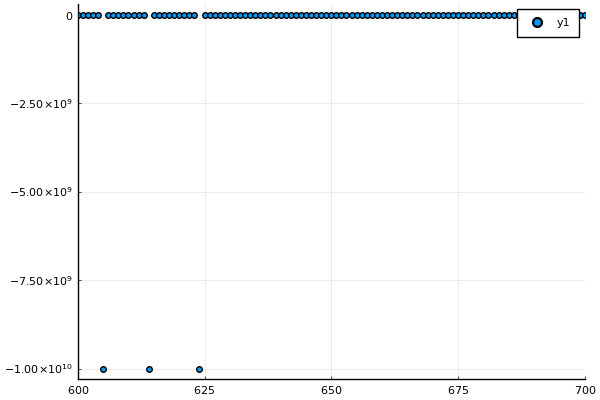

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [103]:
scatter(tube_hist_u[150],xlim=(600,700))

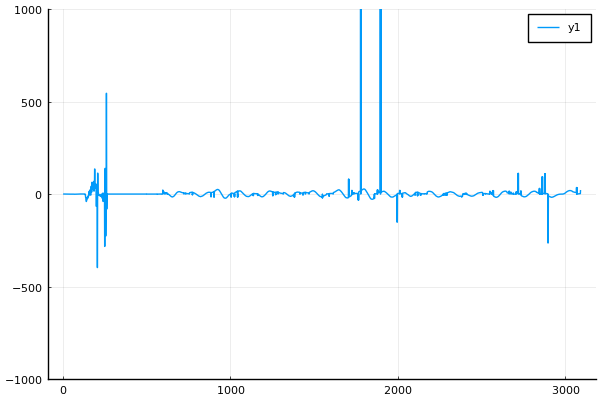

In [147]:
plot(ODE_innertube(tube_hist_u[150],integrator_tube.p,integrator_tube.t),ylim=(-1000,1000))

In [175]:
Hflux

3586.8293590664407

In [174]:
δ=3e-5;
Hflux = Hfilm(δ,sysfinal[150]);
peri = sysfinal[150].tube.peri;
ΔT = 1;
T = 333;
d = sysfinal[150].tube.d;
P = TtoP(T);
Hfg = PtoHfg.(P);
heatflux = Hflux * ΔT
dMdt = heatflux*peri/Hfg
ρ = PtoD(T)
M = ρ * 1 * d * d
# Hfg

1.2943497292809935e-8

In [172]:
dMdt*1e-3

4.462985043188258e-8

In [105]:
ρₗ = sysfinal[end].liquid.ρ
μₗ = sysfinal[end].liquid.μₗ
V = [elem[2] for elem in sysfinal[end].liquid.dXdt];
Re_list = ρₗ .* abs.(V) .* sysfinal[end].tube.d ./ μₗ;

In [106]:
plot(V);

In [107]:
plot(Re_list)

In [109]:
f_coefficient = f_churchill.(Re_list .+ 1e-4)
plot(f_coefficient)

In [111]:
dXdt_to_stress = -0.125 .* f_coefficient .* ρₗ .* V .* abs.(V)
plot(dXdt_to_stress)

In [115]:
plot(-8*μₗ/1e-3 .* V)

In [121]:
Lliquidslug = XptoLliquidslug(sysfinal[end].liquid.Xp,sysfinal[end].tube.L);
lhs = ρₗ*sysfinal[end].tube.Ac .* Lliquidslug;

In [122]:
plot(lhs)

In [94]:
Re_list = ρₗ .* abs.(V) .* d ./ μₗ

LoadError: UndefVarError: ρₗ not defined

In [125]:
rhs_dXdt = sysfinal[end].tube.peri .* Lliquidslug .* dXdt_to_stress ./ lhs;
plot(rhs_dXdt)

In [158]:
rhs_press = sysfinal[end].tube.Ac ./ lhs;
maximum(rhs_press)

0.17149085480031662

In [154]:
 i = 150

maximum(sysfinal[i].vapor.P) - minimum(sysfinal[i].vapor.P)

13375.727313809795

In [160]:
1.3e4*0.17*1e-3

2.21

In [163]:
TtoP(302) - TtoP(300)

16173.609298537136

In [140]:
plot(sysfinal[3].vapor.P)

In [129]:
maximum(sysfinal[end].vapor.P)-minimum(sysfinal[end].vapor.P)

13375.727313809795

In [428]:
P = sysfinal[end].vapor.P[1];
tube_d = sysfinal[end].tube.d;
ρₗ = sysfinal[end].liquid.ρ;
kₗ = p_fluid.kₗ
Cpₗ = p_fluid.Cpₗ

2460.914915292713

In [423]:
p_fluid = SaturationFluidProperty(fluid_type,Tref);

In [425]:
? p_fluid;

In [476]:
P = TtoP(292)

200049.63870177418

In [483]:
Hfg

367635.9321929768

In [485]:
ΔTthres

1.3694123793882245

In [486]:
ρv

5.128744108297353

In [487]:
ρₗ

580.8099892238893

In [478]:
Hfg = PtoHfg(P)
Rn = 3e-6
Tref = PtoT(P)
ρv = PtoD(P)
ΔTthres = RntoΔT(Rn,Tref,fluid_type,tube_d)

A = (2 * (ΔTthres/Tref) * Hfg*ρv/ρₗ)^0.5
Ja = ΔTthres*Cpₗ*ρₗ/ρv/Hfg
B = (12*kₗ/pi/ρₗ/Cpₗ)^0.5 * Ja

0.0005454203750448368

In [479]:
t = 0:1e-6:1e0
tstar = t .* A^2 ./ B^2

0.0:102.35606572343542:1.0235606572343542e8

In [480]:
A

5.518082000052756

In [481]:
Rplus = 2/3 .* ((tstar .+ 1).^1.5 .- (tstar).^1.5 .- 1);
R = Rplus .* B^2 ./ A;

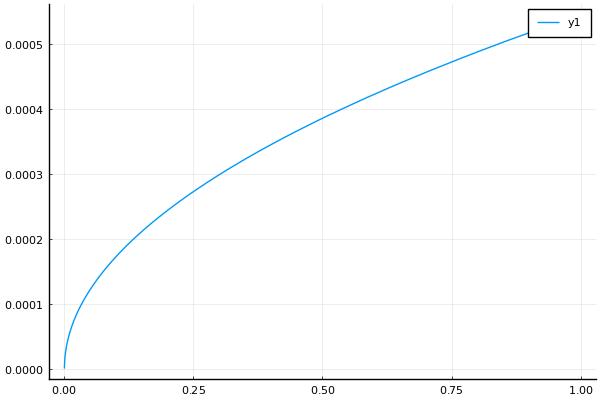

In [482]:
plot(t,R)

In [119]:
vp.δfilm_deposit

2.0e-5

In [120]:
vp.δfilm_deposit

2.0e-5

In [84]:
sysfinal[50].vapor.δstart

18-element Vector{Float64}:
 2.0485477065541057e-5
 1.6188709652418546e-5
 1.1593326086375765e-5
 1.1692132340637229e-5
 1.1854394393726746e-5
 1.1503900746532351e-5
 1.1792685046009128e-5
 1.4477750772371384e-5
 1.3457480930517368e-5
 1.3432984913073102e-5
 1.3135928798154856e-5
 1.5185631632550128e-5
 4.9999118622201146e-5
 4.9996693965218976e-5
 2.074881861770518e-5
 1.7686692257444805e-5
 3.4582922362786804e-5
 1.6152773234490235e-5

In [85]:
sysfinal[49].vapor.δstart

15-element Vector{Float64}:
 1.3876661529989759e-5
 1.5215784705358995e-5
 1.5453248088906697e-5
 1.3598364794935203e-5
 1.3321970420919381e-5
 9.805689749545145e-6
 9.632608666993431e-6
 1.4560090701543365e-5
 1.336539646087547e-5
 1.3414871654181495e-5
 1.4329981257408062e-5
 1.5116734527568219e-5
 1.8801791389842837e-5
 1.9550886178090447e-5
 1.3782055926616424e-5